# Ignorar

In [1]:
#hide
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [2]:
#hide
# from fastbook import *

# Guardar en Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Tabla de contenidos

- [1 - Librerías](#lib)
- [2 - Paths para proyecto](#path)
- [3 - Metadata](#meta)
- [4 - Carga de imágenes y metadata](#carga)
- [5 - Preprocesamieto de las imágenes](#prepro)
- [6 - Train/Test split](#traintest)
- [7 - Modelo](#model)

<a name='lib'></a>
## Librerías

In [1]:
from fastai.vision.all import *
from utils_ATSIA import *

import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

<a name='path'></a>
## Paths para proyecto

In [2]:
organos = ["AmpollaRectal", "Branquias", "Hepatopancreas", "Intestino", "Uropodo"]
grados = ["G0", "G1", "G2", "G3", "G4"]

#Necesitamos la cantidad de caracteres que cada nomenclatura tiene para cada órgano
organo_len = {"AmpollaRectal" : 10, "Branquias" : 25, "Hepatopancreas" : 27, "Intestino" : 27, "Uropodo" :4}

In [3]:
main_path = Path(os.getcwd()) #Cuando estemos en local
# main_path = "/content/drive/MyDrive/ATSIA" #Cuando usamos Google Drive
path = {}
path["data"] = {}
path["img"] = {}
path["metadata"] = {}

for organo in organos:
    path["data"][organo] = os.path.join(main_path, "data", organo, f"X_{organo}.npy")
    path["img"][organo] = os.path.join(main_path, "img", organo)
    path["metadata"][organo] = os.path.join(main_path, "metadata", organo, f"metadata_{organo}.csv")

In [4]:
#Por el momento vamos a utilizar solo el órgano Hepatopancreas
organo = "Hepatopancreas"

In [24]:
SIZE = 200

<a name='meta'></a>
## Metada

In [6]:
metadata = get_metadata(path = path["img"][organo], organo = organo, organo_len = organo_len)
metadata.to_csv(path_or_buf = path["metadata"][organo], index=False)
metadata

,img_name,labels
0,DT_G0-DC_G0-L_000-M_G2-N_G0.png,DT_G0 DC_G0 L_000 M_G2 N_G0
1,DT_G0-DC_G0-L_020-M_G0-N_G0.png,DT_G0 DC_G0 L_020 M_G0 N_G0
2,DT_G0-DC_G0-L_030-M_G0-N_G0 (2).png,DT_G0 DC_G0 L_030 M_G0 N_G0
3,DT_G0-DC_G0-L_030-M_G0-N_G0.png,DT_G0 DC_G0 L_030 M_G0 N_G0
4,DT_G0-DC_G0-L_040-M_G0-N_G0 (2).png,DT_G0 DC_G0 L_040 M_G0 N_G0
...,...,...
605,DT_G4-DC_G4-L_020-M_G3-N_G4.png,DT_G4 DC_G4 L_020 M_G3 N_G4
606,DT_G4-DC_G4-L_020-M_G4-N_G4 (2).png,DT_G4 DC_G4 L_020 M_G4 N_G4
607,DT_G4-DC_G4-L_020-M_G4-N_G4.png,DT_G4 DC_G4 L_020 M_G4 N_G4
608,DT_G4-DC_G4-L_030-M_G2-N_G4.png,DT_G4 DC_G4 L_030 M_G2 N_G4


<a name='carga'></a> 
## Carga de imágenes y metadata 

In [9]:
metadata_csv = pd.read_csv(path["metadata"][organo], sep = ",")
metadata_csv.sample(3)

,img_name,labels
555,DT_G3-DC_G3-L_020-M_G0-N_G1.png,DT_G3 DC_G3 L_020 M_G0 N_G1
205,DT_G1-DC_G0-L_080-M_G0-N_G0 (10).png,DT_G1 DC_G0 L_080 M_G0 N_G0
297,DT_G1-DC_G1-L_090-M_G0-N_G0 (13).png,DT_G1 DC_G1 L_090 M_G0 N_G0


### Constructing a DataBlock

In [11]:
# # check for mislabelled data
# b = []

# for i,v in enumerate(metadata_csv["labels"]):
#     a = v.split(" ")
#     for val in a:
#         if val not in b:
#             b.append(val)
#             if val == "N_G0.":
#                 print(v)
# b

In [19]:
img = PILImage(PILImage.create("TEST_IMAGE.png").resize((600,400)))
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

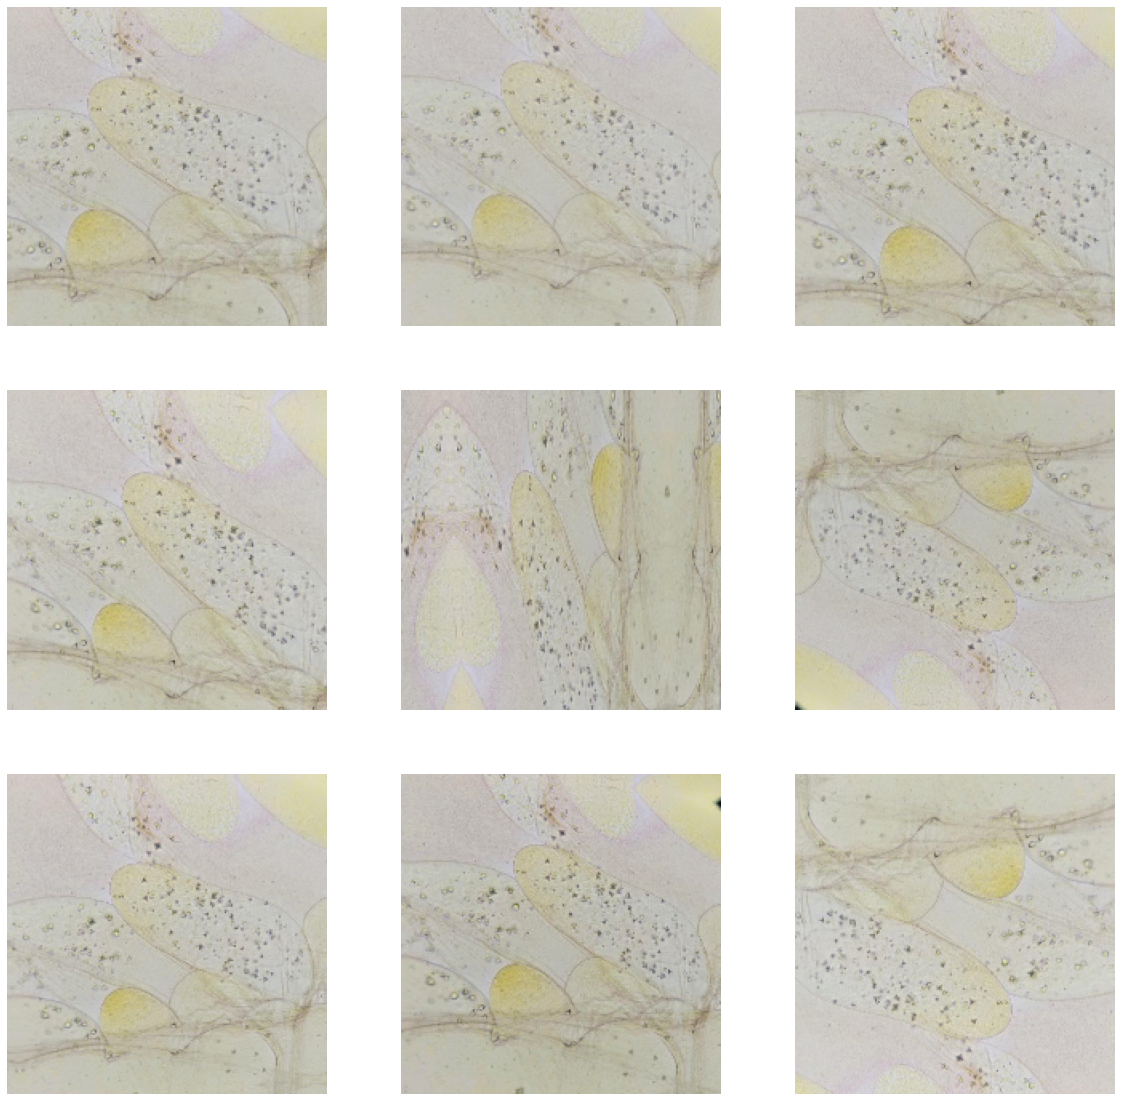

In [65]:
tfms = aug_transforms(mult=1.0, 
                      do_flip=True, 
                      flip_vert=True, 
                      max_rotate=10.0, 
                      min_zoom=1.0, 
                      max_zoom=1.2, 
                      max_lighting=0.1, 
                      max_warp=0.1, 
                      p_affine=0.75, 
                      p_lighting=0.75, 
                      xtra_tfms=None, 
                      size=(200,200), 
                      mode='bilinear', 
                      pad_mode='reflection', 
                      align_corners=True, 
                      batch=False, 
                      min_scale=1.0)
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(3,3, figsize=(20,20))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

In [73]:
def get_x(r): return Path(path["img"][organo], r['img_name'])
def get_y(r): return r['labels'].split(' ')


dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, 
                   get_y = get_y, 
                   item_tfms = aug_transforms(mult=1.0, 
                                              do_flip=True, 
                                              flip_vert=True, 
                                              max_rotate=10.0, 
                                              min_zoom=1.0, 
                                              max_zoom=1.2, 
                                              max_lighting=0.1, 
                                              max_warp=0.1, 
                                              p_affine=0.75, 
                                              p_lighting=0.75, 
                                              xtra_tfms=None, 
                                              size=(200,200), 
                                              mode='bilinear', 
                                              pad_mode='reflection', 
                                              align_corners=True, 
                                              batch=False, 
                                              min_scale=1.0)
                  )
dsets = dblock.datasets(metadata_csv)
dsets.train[0]

(PILImage mode=RGB size=2040x1528,
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]))

In [74]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#5) ['DC_G4','DT_G1','L_070','M_G4','N_G0']

And now we can display a sample of our data:

In [72]:
dls = dblock.dataloaders(metadata_csv)
dls.show_batch(nrows=3, ncols=2, figsize=(10,10))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Could not do one pass in your dataloader, there is something wrong in it


RuntimeError: "check_uniform_bounds" not implemented for 'Byte'

Remember that if anything goes wrong when you create your `DataLoaders` from your `DataBlock`, or if you want to view exactly what happens with your `DataBlock`, you can use the `summary` method we presented in the last chapter.

Our data is now ready for training a model. As we will see, nothing is going to change when we create our `Learner`, but behind the scenes, the fastai library will pick a new loss function for us: binary cross-entropy.

### Binary Cross-Entropy

In [31]:
learn = cnn_learner(dls, resnet50, metrics = partial(accuracy_multi, thresh=0.5)) 
#usamos partial para indicar un nuevo parametros a la función accuracy_multi que tiene como default thresh = 0.5
#Usa la funcion de perdida de BCEWithLogitsLoss automáticamente al ser multi-label classification

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.049088,0.819168,0.202114,00:50
1,1.019512,0.777475,0.231234,00:52
2,0.972630,0.814312,0.261001,00:52
3,0.929035,0.768990,0.269413,00:50


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.774660,0.782657,0.237058,00:49
1,0.740956,0.756682,0.266393,00:49
2,0.713510,0.651605,0.233822,00:51


In [75]:
x, y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

RuntimeError: "check_uniform_bounds" not implemented for 'Byte'

In [ ]:
learn.fine_tune(10, base_lr=3e-3, freeze_epochs=5)

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

If you pick a threshold that's too high, you'll only be selecting the objects for which your model is very confident:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [ ]:
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default `get_preds` applies the output activation function (sigmoid, in this case) for us, so we'll need to tell `accuracy_multi` to not apply it:

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

We can now use this approach to find the best threshold level:

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [50]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

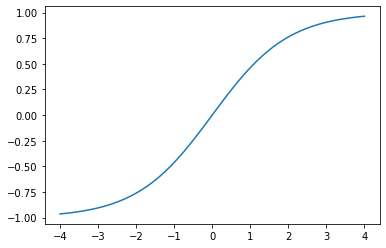

In [52]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

We didn't specify a loss function, which means we're getting whatever fastai chooses as the default. Let's see what it picked for us:

In [53]:
dls.loss_func

FlattenedLoss of MSELoss()

This makes sense, since when coordinates are used as the dependent variable, most of the time we're likely to be trying to predict something as close as possible; that's basically what `MSELoss` (mean squared error loss) does. If you want to use a different loss function, you can pass it to `cnn_learner` using the `loss_func` parameter.

Note also that we didn't specify any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root). 

We can pick a good learning rate with the learning rate finder:

SuggestedLRs(valley=0.0030199517495930195)

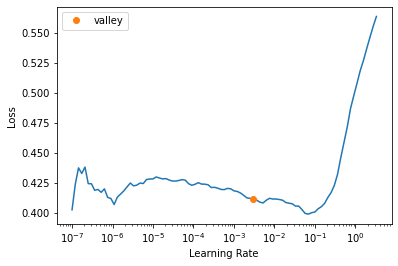

In [54]:
learn.lr_find()

We'll try an LR of 1e-2:

In [55]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.051653,0.005350,01:12


epoch,train_loss,valid_loss,time
0,0.008164,0.000553,01:26
1,0.002982,0.000103,01:22
2,0.001349,0.000069,01:22


Generally when we run this we get a loss of around 0.0001, which corresponds to an average coordinate prediction error of:

This sounds very accurate! But it's important to take a look at our results with `Learner.show_results`. The left side are the actual (*ground truth*) coordinates and the right side are our model's predictions:

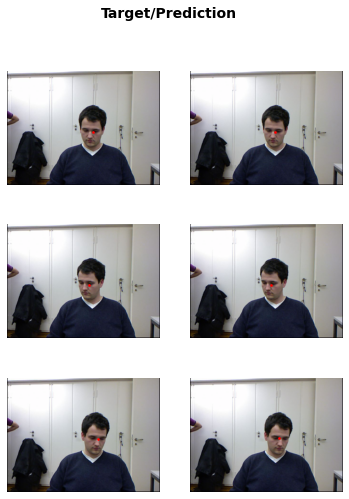

In [57]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## Conclusion

In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different numbers of outputs. The loss function is the one thing that changes, which is why it's important to double-check that you are using the right loss function for your problem.

fastai will automatically try to pick the right one from the data you built, but if you are using pure PyTorch to build your `DataLoader`s, make sure you think hard when you have to decide on your choice of loss function, and remember that you most probably want:

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression